# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [67]:
% matplotlib inline

import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [2]:
#Read the data. This is using the full dataset of 10.7M rows.  It is current through 12/30/16.
df = pd.read_csv('Iowa_Liquor_Sales.csv')

df.shape

/Users/chris/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10707980, 24)

In [3]:
new_names = []
for col in df.columns:
    name = (col.replace(' ','_').encode('ascii','ignore'))
#    name = name.replace('(ml)','')
    name = name.replace(')','').replace('(','')
    new_names.append(name.lower())
df.columns = new_names

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10083835 entries, 0 to 10682367
Data columns (total 24 columns):
invoice/item_number    object
date                   object
store_number           int64
store_name             object
address                object
city                   object
zip_code               int64
store_location         object
county_number          float64
county                 object
category               float64
category_name          object
vendor_number          float64
vendor_name            object
item_number            int64
item_description       object
pack                   int64
bottle_volume_ml       int64
state_bottle_cost      object
state_bottle_retail    object
bottles_sold           int64
sale_dollars           object
volume_sold_liters     float64
volume_sold_gallons    float64
dtypes: float64(5), int64(6), object(13)
memory usage: 1.9+ GB


In [6]:
df.head()

,invoice/item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S29198800001,11/20/2015,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,6,$162.84,4.50,1.19
1,S29195400002,11/21/2015,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,12,$325.68,9.00,2.38
2,S29050300001,11/16/2015,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08
3,S28867700001,11/04/2015,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,...,237,Knob Creek w/ Crystal Decanter,3,1750,$35.55,$53.34,3,$160.02,5.25,1.39
4,S29050800001,11/17/2015,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08


## Inital Fndings

The state_bottle_retail appears to be a constant 50% mark up of state_bottle_cost, except for a few sale items.  This data represents the sales to retailers, which makes describing actual sales and profit of a retailer difficult. Since there is no direct information about the actual sales, in dollars, of the retailers, estimates of their sales will be based on the their inventory purchasing habits.


## Further Cleaning

There is a great deal of duplicate data in the raw data.  Along with data type conversion, fields that are repeated will be pushed into a separate dataframes, then referenced through a common key value.  Specifically, dataframes for items, categories, vendors, county names and stores will be created and the duplicate fields will be purged from the main data table. Later, dataframes with additional infomation about locations maybe created.

Empty values or inappropriate values are uncommon (less than 0.1% of instances).  These values will be dropped rather than inputed or corrected.

In [7]:
#Clean ZipCode and convert to integers.  This is discrete not continuous.  
#Converting to integers adds linking datafrmaes
df['zip_code'].fillna('xxx',inplace = True)
mask = (df['zip_code'].str.isnumeric().fillna(False))
mask = mask.fillna(True)
df = df[mask]
df['zip_code'] = df['zip_code'].astype('int')

In [9]:
#Convert Category from float to integer and fill junk with 0
#Remove the Category Name column from the main dataframe.  But set aside the data for later use.
df['category'].fillna(0,inplace=True)
df['category'] = df['category'].astype('int')
category_df = df.groupby(['category'], as_index = False )['category_name'].first()

#Convert ItemNumber to interger.  If there are bad values, it will throw an error.
#Extract ItemDescription and create a DataFrame linking ItemNumber and Item Description
df['item_number'] = df['item_number'].astype('int')
item_df = df.groupby(['item_number'], as_index = False )['item_description'].first()

#Fill CountyNumber with 0s and convert to integer
#Extract County and create a DataFrame linking CountyNumber and County
df['county_number'].fillna(0,inplace=True)
df['county_number'] = df['county_number'].astype('int')
county_df = df.groupby(['county_number'], as_index = False )['county'].first()

#Extract VendorName and create a DataFrame linking VendorNumber and VendorName
vendor_df = df.groupby(['vendor_number'], as_index = False )['vendor_name'].first()
df['vendor_number'].fillna(0,inplace=True)
df['vendor_number'] = df['vendor_number'].astype('int')

#Extract Store information and create a DataFrame linking StoreNumber to Name and Location information
store_df = df.groupby(['store_number','store_name','address','city','zip_code'], 
                      as_index = False )['store_location'].first()

#Ignore these for now, These can be used to create database tables, once a database engin is selected.
#category_df.to_sql("category", engine,if_exists='replace')
#item_df.to_sql('item', engine, if_exists='replace')
#county_df.to_sql('county', engine, if_exists='replace')
#vendor_df.to_sql('vendor', engine, if_exists='replace')
#store_df.to_sql('store', engine, if_exists='replace')

In [10]:
del df["category_name"]
del df["item_description"]
del df["county"]
del df["vendor_name"]
del df["store_name"]
del df["address"]
del df['store_location']

In [11]:
#Convert Dates to datetime object
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

# Remove $ from certain columns and convert from string to float
cols = ['state_bottle_cost', "state_bottle_retail", "sale_dollars"]
for col in cols:
        df[col] = df[col].str.replace('\$','').astype('float')


In [12]:
mask2 = df['volume_sold_gallons'] != 0
df = df[mask2]

Combining information from the category label and a Iowa Spirits price book, the category number uses a rubric of XXXyxxx. The first three numbers are the broad category of the spirit, the fourth number indicates if the spirit has been imported, then the last numbers are a sub-category of the spirits. The broad categories are defined in the dictionary below. This information may or may not be used in analysis.

In [13]:
broad_cate_dict = {101: 'Whiskeies', 102: 'Tequilas', 103:'Vodkas', 104:'Gins', 
                   105:'Brandies', 106: 'Rums', 107: 'Cocktails', 108: 'Cordials and Liqueurs',
                  109: "Neutral Spirits",110:'American Alcohol', 150 :"HIGH PROOF BEER", 170:'SPECIALTY PACKAGES'}
origin_dict = {1: 'American', 2: 'Imported'}


# Mine the data
Create new computed fields and group data to make it more useful.

In [14]:
# Margin and Price per liter
df['%markup'] = (df['state_bottle_retail']-df['state_bottle_cost'])/df['state_bottle_cost']
df['sales_per_liter'] = df['sale_dollars']/df['volume_sold_liters']

In [15]:
df['%markup'].describe()

count    1.008074e+07
mean     5.033235e-01
std      1.682180e-02
min     -8.399634e-01
25%               NaN
50%               NaN
75%               NaN
max      2.500000e+00
Name: %markup, dtype: float64

In [16]:
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['period'] = df['date'].apply(lambda(x):"{} Q{}".format(x.year,x.quarter))

# Create some models

Model 1 is change in first quarter sales multipled by annual sales.
Model 2 four times q1 sales.
model 3 is the average of model 1 and 2

## Scenario 1: Analysis
Calculate the yearly liquor sales for each score using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable.

In [17]:
#Create dataframes dscribing sales per store per time range
sales_per_store_pt = df.pivot_table('sale_dollars','store_number','year',aggfunc='sum')
annual_sales_per_store_df = pd.DataFrame(sales_per_store_pt.to_records())
sales_per_store_pt2 = df.pivot_table('sale_dollars','store_number','period',aggfunc='sum')
quarterly_sales_per_store_df = pd.DataFrame(sales_per_store_pt2.to_records())

In [18]:
annual_sales_per_store_df.head()

,store_number,2012,2013,2014,2015,2016
0,2106,992310.70,1040650.27,1342161.28,1434369.85,710018.98
1,2113,37908.58,99257.86,99913.51,85763.42,57607.34
2,2130,1038701.83,1065606.14,1034376.03,1108184.99,625625.14
3,2132,57185.95,NaN,NaN,NaN,NaN
4,2152,99460.09,106852.55,94892.90,72080.36,12782.78


# Create some models

Model 1 is change in first quarter sales multipled by annual sales.
Model 2 four times q1 sales.
Model 3 is the mean of model 1 and 2.


In [19]:
model_df = pd.merge(annual_sales_per_store_df[['store_number','2014','2015']], 
         quarterly_sales_per_store_df[['store_number','2014 Q1','2015 Q1']], on='store_number')
model_df.dropna(inplace=True)
model_df['q1_change 14-15'] = model_df['2015 Q1']/model_df['2014 Q1']

In [20]:
model_df['2015_predict1'] = model_df['q1_change 14-15']*model_df['2014']
model_df['2015_predict2'] = model_df['2015 Q1']*4
model_df['2015_predict3'] = (model_df['2015_predict1'] + model_df['2015_predict2'])/2

### Use your model for 2015 to estimate total sales for each store in 2016, extrapolating from the sales so far for Jan-March of 2016.

Model 3 provided the best estimate for 2015 sales. Applying this model to the first quarter of 2016 sales,total sales of spirits is expectged to be \$271,856,349 in 2016. This is a decrease of sales from 2015 of about \$13M. Tuning the model parameters decrease the estimate by \$8M.
Lasso didn't improve the performance of this model significantly over Lasso's performance.


In [21]:
model_df[['2014','2015',
                  '2015_predict1',
                  '2015_predict2',
                  '2015_predict3']].sum()

2014             2.634346e+08
2015             2.638078e+08
2015_predict1    2.875641e+08
2015_predict2    2.397765e+08
2015_predict3    2.636703e+08
dtype: float64

In [22]:
model2_df = pd.merge(annual_sales_per_store_df[['store_number','2015','2016']], 
         quarterly_sales_per_store_df[['store_number','2015 Q1','2016 Q1']], on='store_number')

model2_df.dropna(inplace=True)

model2_df['q1_change 15-16'] = model2_df['2016 Q1']/model2_df['2015 Q1']
model2_df['2016_predict1'] = model2_df['q1_change 15-16']*model2_df['2015']
model2_df['2016_predict2'] = model2_df['2016 Q1']*4
model2_df['2016_predict3'] = (model2_df['2016_predict1'] + model2_df['2016_predict2'])/2

In [23]:
from sklearn.metrics import make_scorer, r2_score
r_scorer = make_scorer(r2_score)

In [24]:
y = model_df['2015']
X = model_df.drop('2015', axis=1)
X.drop(['2015_predict1','2015_predict2','2015_predict3','store_number'], axis =1, inplace =True)

In [25]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score

In [26]:
cross_val_scores = cross_val_score(Lasso(normalize=True), X, y, scoring=r_scorer, cv=6)
cross_val_scores

array([ 0.98954583,  0.96738478,  0.94735167,  0.98004561,  0.98928221,
        0.99729192])

In [27]:
alphas = [1E-5, 1E-4, 1E-3, 0.01, 0.1, 1, 10, 100, 1000]

for alp in alphas:
    LASSO = Lasso(alpha=alp, max_iter=1E5, normalize=True)
    cross_val_scores = cross_val_score(LASSO, X, y, scoring=r_scorer)
    mean_mse = np.mean(cross_val_scores)
    print("Mean MSE for alpha={:6} is {:.2f}".format(alp, mean_mse))

Mean MSE for alpha= 1e-05 is 0.98
Mean MSE for alpha=0.0001 is 0.98
Mean MSE for alpha= 0.001 is 0.98
Mean MSE for alpha=  0.01 is 0.98
Mean MSE for alpha=   0.1 is 0.98
Mean MSE for alpha=     1 is 0.98
Mean MSE for alpha=    10 is 0.98
Mean MSE for alpha=   100 is 0.98
Mean MSE for alpha=  1000 is 0.98


In [28]:
regression = Lasso(alpha=.001)
regression.fit(X,y)

/Users/chris/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
print X.columns
regression.coef_

Index([u'2014', u'2014 Q1', u'2015 Q1', u'q1_change 14-15'], dtype='object')


array([  7.26150972e-01,  -2.59950566e+00,   3.66210597e+00,
        -7.92606678e+03])

The model goes to 2015 = .72615 2014income -2.5995 (2014 Q1 income) + 3.6621 (2015 Q1 income) + -7926 (Q1 2015 / Q1 2014)

Checking predction:


In [30]:
model2_df.drop(['store_number','2016','2016_predict1','2016_predict2','2016_predict3'], axis =1, inplace = True)

In [31]:
regression.predict(model2_df).sum() #Predicted income for 2016


245865779.10030288

# Scenario 2

Predict sites for a new store front

Add data from Zipatlas.com.  Median Income and population per zip code in Iowa.

In [32]:
zip_pop_df = pd.read_csv('zip-pop',delimiter='\t')
zip_inc_df = pd.read_csv('zip-income',delimiter='\t')
zip_inc_df.drop(['rank','location','city','population'], axis=1, inplace = True)
zip_inc_df.columns = ['zip_code','ave_income']
zip_pop_df.columns = ['#','zip_code','location','city','population','pop-density']
zip_pop_df.drop('#', axis = 1, inplace = True)
zip_data_df = pd.merge(zip_pop_df,zip_inc_df,on='zip_code')
zip_data_df['city'] = zip_data_df['city'].str[:-6]

In [35]:
# Create masks to select data from given years and fix for an error in the data.
mask_2012 = (df['year'] == 2012)
mask_2013 = (df['year'] == 2013)
mask_2014 = (df['year'] == 2014)
mask_2015 = (df['year'] == 2015)
mask_2016 = (df['year'] == 2016) & (df['zip_code'] != 0)


In [36]:
#Create summaries for sales per zip code
zip_2014_df = df[mask_2014][['sale_dollars','volume_sold_liters',
                             'sales_per_liter','zip_code','bottles_sold']].groupby(
                              by = ['zip_code'],as_index=False).sum()
zip_store_df = df[mask_2014].groupby(['store_number'], as_index=False)[['zip_code']].first()
zip_store_df = zip_store_df.groupby('zip_code',as_index = False)['store_number'].count()
zip_2014_summary_df = pd.merge(zip_2014_df, zip_store_df, on = 'zip_code')

zip_2012_df = df[mask_2012][['sale_dollars','volume_sold_liters',
                             'sales_per_liter','zip_code','bottles_sold']].groupby(
                              by = ['zip_code'],as_index=False).sum()
zip_store_df = df[mask_2012].groupby(['store_number'], as_index=False)[['zip_code']].first()
zip_store_df = zip_store_df.groupby('zip_code',as_index = False)['store_number'].count()
zip_2012_summary_df = pd.merge(zip_2012_df, zip_store_df, on = 'zip_code')

zip_2013_df = df[mask_2013][['sale_dollars','volume_sold_liters',
                             'sales_per_liter','zip_code','bottles_sold']].groupby(
                              by = ['zip_code'],as_index=False).sum()
zip_store_df = df[mask_2013].groupby(['store_number'], as_index=False)[['zip_code']].first()
zip_store_df = zip_store_df.groupby('zip_code',as_index = False)['store_number'].count()
zip_2013_summary_df = pd.merge(zip_2013_df, zip_store_df, on = 'zip_code')

zip_2015_df = df[mask_2015][['sale_dollars','volume_sold_liters',
                             'sales_per_liter','zip_code','bottles_sold']].groupby(
                              by = ['zip_code'],as_index=False).sum()
zip_store_df = df[mask_2015].groupby(['store_number'], as_index=False)[['zip_code']].first()
zip_store_df = zip_store_df.groupby('zip_code',as_index = False)['store_number'].count()
zip_2015_summary_df = pd.merge(zip_2015_df, zip_store_df, on = 'zip_code')

zip_2016_df = df[mask_2016][['sale_dollars','volume_sold_liters',
                             'sales_per_liter','zip_code','bottles_sold']].groupby(
                              by = ['zip_code'],as_index=False).sum()
zip_store_df = df[mask_2016].groupby(['store_number'], as_index=False)[['zip_code']].first()
zip_store_df = zip_store_df.groupby('zip_code',as_index = False)['store_number'].count()
zip_2016_summary_df = pd.merge(zip_2016_df, zip_store_df, on = 'zip_code')

In [37]:
zip_2016_summary_df.sort_values(by='volume_sold_liters',ascending=False).head()

,zip_code,sale_dollars,volume_sold_liters,sales_per_liter,bottles_sold,store_number
365,52402,6011179.87,363906.26,2.017186e+06,400358,28
94,50320,6664189.88,362541.24,1.178290e+06,386780,9
329,52240,5957459.73,334406.65,2.007842e+06,390158,24
90,50314,6927020.82,331354.56,1.767707e+06,397303,6
4,50010,4646154.79,282968.64,1.528094e+06,286798,22


In [38]:
zip_summary = pd.merge(zip_2016_summary_df,zip_2015_summary_df, on = 'zip_code', suffixes= ('2016','2015'))
zip_summary = pd.merge(zip_summary,zip_2014_summary_df, on = 'zip_code')
zip_summary = pd.merge(zip_summary,zip_2013_summary_df, on = 'zip_code', suffixes= ('2014','2013'))
zip_summary['1_year_sales_delta'] = ((zip_summary['sale_dollars2016'] - zip_summary['sale_dollars2015']))
zip_summary['2_year_sales_delta'] = ((zip_summary['sale_dollars2015']) - (zip_summary['sale_dollars2014']))
zip_summary['3_year_sales_delta'] = ((zip_summary['sale_dollars2014']) - (zip_summary['sale_dollars2013']))
zip_summary['2016_sales_per_store'] = ((zip_summary['sale_dollars2016']/zip_summary['store_number2016']))
zip_summary['2015_sales_per_store'] = ((zip_summary['sale_dollars2015']/zip_summary['store_number2015']))
zip_summary['2014_sales_per_store'] = ((zip_summary['sale_dollars2014']/zip_summary['store_number2014']))
zip_summary['2013_sales_per_store'] = ((zip_summary['sale_dollars2013']/zip_summary['store_number2013']))

In [79]:
zip_model = zip_summary[['zip_code','1_year_sales_delta','2_year_sales_delta',
                        '3_year_sales_delta','2015_sales_per_store',
                        '2014_sales_per_store','2013_sales_per_store']]
zip_model['zip_code'] = zip_model['zip_code'].astype('string')

/Users/chris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
zip_model.head()

,zip_code,1_year_sales_delta,2_year_sales_delta,3_year_sales_delta,2015_sales_per_store,2014_sales_per_store,2013_sales_per_store
0,50002,-6.169110e+03,-6569.020000,5459.980000,19357.015000,22641.525000,19911.535000
1,50003,-1.413939e+05,51114.390000,-35000.020000,114962.523333,97924.393333,109591.066667
2,50006,-3.796928e+04,10838.850000,2618.080000,52579.260000,47159.835000,45850.795000
3,50009,-7.918003e+05,200261.330000,83521.590000,267713.183333,245461.924444,236181.747778
4,50010,-2.687859e+06,156410.029999,436770.759999,349238.748095,341790.651429,337041.646000


### Define a model to use
The target is 1 year change in sales in a Zip code.  This is being used as a proxy for predicting increasing demand in an area.  Modeling on current store sales will lead to selecting a location with the greatest supply, which is like chasing other people's performance and entering an established market.  Finding a location with unmet demand shuould lead to greater growth.

In [81]:
y = zip_model['1_year_sales_delta']
z = zip_model["zip_code"]
X = zip_model.drop(['1_year_sales_delta',"zip_code"], axis=1)
cross_val_scores = cross_val_score(Lasso(normalize=True), X, y, scoring=r_scorer, cv=10)
cross_val_scores

array([ 0.71118389,  0.48239716,  0.78979894,  0.46312895,  0.44241169,
        0.27596463,  0.36946931,  0.85802156, -0.17120406,  0.69867772])

In [82]:
alphas = [1E-5, 1E-4, 1E-3, 0.01, 0.1, 1, 10, 100, 1000,10000,100000]

for alp in alphas:
    LASSO = Lasso(alpha=alp, max_iter=1E5, normalize=True)
    cross_val_scores = cross_val_score(LASSO, X, y, scoring=r_scorer)
    mean_mse = np.mean(cross_val_scores)
    print("Mean r2 for alpha={:6} is {:.2f}".format(alp, mean_mse))

Mean r2 for alpha= 1e-05 is 0.62
Mean r2 for alpha=0.0001 is 0.62
Mean r2 for alpha= 0.001 is 0.62
Mean r2 for alpha=  0.01 is 0.62
Mean r2 for alpha=   0.1 is 0.62
Mean r2 for alpha=     1 is 0.62
Mean r2 for alpha=    10 is 0.62
Mean r2 for alpha=   100 is 0.62
Mean r2 for alpha=  1000 is 0.62
Mean r2 for alpha= 10000 is 0.46
Mean r2 for alpha=100000 is -0.04


In [83]:
regression = Lasso(alpha=1)
regression.fit(X,y)
zip(X.columns, regression.coef_)

[('2_year_sales_delta', -0.64240693283069017),
 ('3_year_sales_delta', -1.9786730220778834),
 ('2015_sales_per_store', -0.90648754662828757),
 ('2014_sales_per_store', 0.5190159108398672),
 ('2013_sales_per_store', -1.3219490588289955)]

In [84]:
predictions = {x:z for (x,z) in zip(regression.predict(X),z)}
predictions

{-3770884.9690464227: '50314',
 -3102507.1698961598: '50320',
 -2281636.572141489: '52001',
 -2138686.1079137721: '52240',
 -2074089.9478730841: '52241',
 -1693174.684630547: '50266',
 -1676748.2488582928: '52807',
 -1663879.8740358935: '52411',
 -1646181.9153494225: '50263',
 -1588139.0630114207: '52401',
 -1517099.5321445866: '50311',
 -1489160.2712249376: '50010',
 -1442681.9630309299: '51106',
 -1315414.7793406849: '52722',
 -1305921.1023946435: '50023',
 -1288065.789861293: '52632',
 -1242246.8368017522: '52314',
 -1237201.4506536319: '51501',
 -1161864.7714055732: '51351',
 -1142928.9671262975: '52804',
 -1127873.8922577619: '52405',
 -1082925.1510493846: '50310',
 -1064985.2166958156: '50702',
 -1056490.8283604223: '50265',
 -949451.98926854949: '50401',
 -946817.02104435535: '50703',
 -931035.59323173738: '52002',
 -896241.27198664844: '51104',
 -868183.15116432216: '50321',
 -863053.32563983533: '52601',
 -828855.63502116734: '50312',
 -828599.97102838079: '50428',
 -826743.53

In [65]:
#create a data file for use with Tableau 
with open('heat_map_data.csv','a') as f:
    for p,z in predictions.items():
        f.write("{},{}\n".format(z,p))

The below image shows the predict growth of sales for 2016.  This looks like a very weak year for sales growth.  The light blue zip codes are the best 

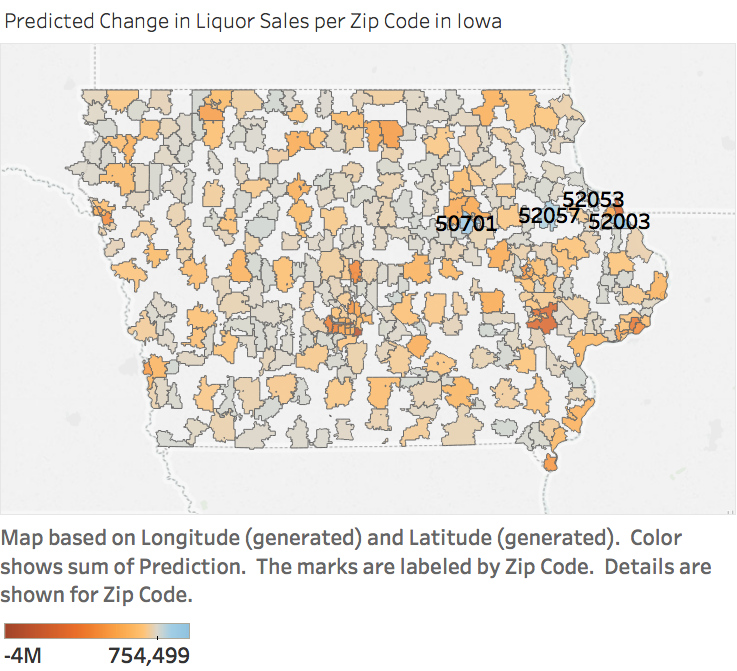

In [69]:
Image("heat_map.png")

### Results

The modeling predicts the zip codes to search for a new store location: 52003, 50701, 52053, 52057.  These locations have the greatest positive change sales.  Three of these zip codes (520XX) are in or near the city of Dubuque.  Examining the map for how zip codes in the area of best predicted performance, there are zip codes with extremely poor performance adjacent to the targeted zip codes.  Overall, the demand for Liquor seems weak and possibly decreasing.  Overall, opening a store front focusing one selling spirits does not seem wise at this moment.  Further analyisis, including estimating demand of other forms of alcohol should be conducted.

The two zip codes showing the greatest shrinkage of sales from year to year are 50314 and 50320.  Entering these markets seems like entering an area of oversupply.





### Things to do next:
Integrate population data.  Median income and population density are the first targets to consider. Also, many of the highest selling areas are near colleges, so an age distribution will be may be siginificant.  However, those area near colleges have high change in the volume and a high number of stores, which might not indicate a successful location. Readjusting the time series to use quarterly changes may provide beter results.  Using gradient decent would provide an interesting  comparison for model evaluation.  As the data becomes available, check the predictions for 2017 Q1 would be instructive for predictive power of the models.  Finally, using a neural net to create a model could be very instructive, as well.